In [ ]:
!pip install vaderSentiment
!pip install textstat

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import sys
import re
import os
from collections import Counter
from textstat.textstat import *


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
#from sklearn.pipeline import Pipeline
import matplotlib.pylab as plt
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stewi_000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\stewi_000\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stewi_000\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\stewi_000\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


-------------------------------------------------------
# **1. Loading Data**
-------------------------------------------------------


In [4]:
dfs = pd.read_csv('C:/Users/stewi_000/Desktop/UNI/Computerlinguistik/SS 20/SNLP/SNLP-OLID Project/OLIDv1.0/olid-training-v1.0.tsv', sep='\t', encoding = 'utf-8')

# **2. Preprocessing**

## **2.1 Automatic Sentiment Analyses of Tweets**

In [5]:
analyzer = SentimentIntensityAnalyzer()

dfs['neg'] = dfs['tweet'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
dfs['neu'] = dfs['tweet'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
dfs['pos'] = dfs['tweet'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
dfs['compound'] = dfs['tweet'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
dfs

,id,tweet,subtask_a,subtask_b,subtask_c,neg,neu,pos,compound
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,0.000,1.000,0.000,0.0000
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,0.247,0.753,0.000,-0.5067
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0.000,0.880,0.120,0.3400
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,0.286,0.714,0.000,-0.5574
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,0.241,0.652,0.108,-0.6240
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,0.000,1.000,0.000,0.0000
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,0.000,0.805,0.195,0.2924
13238,27429,@USER Pussy,OFF,UNT,NaN,0.000,1.000,0.000,0.0000


## **2.2 Tokens Distribution**

In [6]:
all_tweets =dfs["tweet"]


In [7]:
count = 0
num_token_inSentence = []
for sent in all_tweets:
  count = count+1
  word_list = len(sent.split())
  num_token_inSentence.append(word_list)

In [8]:
avg_tokens =sum(num_token_inSentence)/count
print(avg_tokens)

22.307703927492447


In [9]:
dfs["tokens"] = dfs["tweet"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

In [10]:
num = dfs.shape[0]

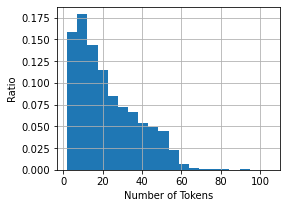

In [11]:
dfs["num_tokens"] = dfs["tokens"].map(len)
ax = dfs["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num)/num)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [12]:
# Write DataFrame to CSV File with Default params.
dfs.to_csv('C:/Users/stewi_000/Desktop/UNI/Computerlinguistik/SS 20/SNLP/SNLP-OLID Project/Automatic_Sentiment_Analyses_of_Tweets.csv')

## **2.3 Creating Dataframe**

In [13]:
tweets_list = dfs['tweet'].to_list()
tweets_to_string = []

for elem in tweets_list:
    string = ''.join(elem)
    tweets_to_string.append(string)
    

In [14]:
dfs.describe()

,id,neg,neu,pos,compound,num_tokens
count,13240.000000,13240.000000,13240.000000,13240.000000,13240.000000,13240.000000
mean,54881.766163,0.120217,0.769305,0.110480,-0.038840,22.474924
std,26092.681658,0.144467,0.173044,0.139423,0.513623,15.315337
min,10006.000000,0.000000,0.105000,0.000000,-0.986000,2.000000
25%,32235.750000,0.000000,0.657000,0.000000,-0.476700,10.000000
50%,54852.000000,0.077000,0.773500,0.065000,0.000000,18.000000
75%,77743.250000,0.202000,0.904000,0.179000,0.401900,32.000000
max,99986.000000,0.885000,1.000000,0.855000,0.986100,105.000000


In [15]:
tweets = dfs["tweet"].copy()

# **3. Methods**

------------------------------------------
## **3.1. Feature Engineering**

**Vectorization**

The following settings for vectorization were used:



*   Word representation: TFIDFVectorizer;
*   N-grams: unigram & bigram & trigram;
*   Convert to lowercase;
*   Try binary counter;
*   Use stop words;

------------------------------------------

### **3.1.1 Creating List with "Stopwords"**

In [16]:

#Tokenize tweets in order to count words
s = ''.join(tweets_to_string)
#get rid of punctuation
sentence = re.sub(r'[^\w\s]','',s.lower())
tokens = nltk.word_tokenize(sentence)

#Tokens Distribution (word occurrences)
occurrences = Counter(tokens).most_common(100)
dictOftokens = dict(occurrences)

#Tokens with occurrences more than 1000
most_common_tokens = []
for k,v in dictOftokens.items():
  most_common_tokens.append(k)

#Get most common tokens to add them to stopwords
print(most_common_tokens) 

['user', 'the', 'is', 'to', 'a', 'and', 'you', 'of', 'are', 'i', 'he', 'in', 'that', 'for', 'she', 'it', 'this', 'on', 'not', 'urluser', 'they', 'with', 'have', 'be', 'gun', 'liberals', 'so', 'all', 'your', 'like', 'what', 'control', 'as', 'but', 'antifa', 'we', 'about', 'just', 'was', 'her', 'if', 'will', 'dont', 'do', 'who', 'its', 'conservatives', 'people', 'no', 'his', 'maga', 'at', 'my', 'by', 'from', 'or', 'how', 'has', 'an', 'their', 'out', 'get', 'can', 'up', 'amp', 'know', 'me', 'one', 'why', 'when', 'because', 'more', 'trump', 'think', 'him', 'would', 'now', 'im', 'should', 'them', 'there', 'our', 'good', 'only', 'right', 'thats', 'us', 'want', 'go', 'were', 'than', 'need', 'see', 'going', 'time', 'never', 'url', 'been', 'being', 'these']


### **3.1.2 Preprocess Methods**

In [17]:
#Creating a list with stopwords
stopwords=stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(most_common_tokens)
stopwords = list(set(stopwords))

In [18]:

#Add preprocess Method
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

#Add method to get rid of Emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

counter = CountVectorizer()
data1 = counter.fit_transform(tweets)
count = pd.DataFrame(data = data1.toarray(), columns = counter.get_feature_names())
unique_words = count.columns[count.sum(axis = 0) == 1]

#Add method to ged rid of unique words
def kick_the_word(s):
    p = re.compile(r"\w+(?:'\w+)*|[^\w\s]")
    b = p.findall(s)
    for word in b:
        if word in unique_words:
            s = s.replace(word, '')
    return s


In [19]:
len(tweets)

13240

In [20]:
#Application of methods
tweets = tweets.apply(lambda x: x.replace('#USER#', '').lower())
tweets = tweets.apply(remove_emoji)
tweets = tweets.apply(kick_the_word)
tweets = tweets.str.replace('[^\w\s]','')

<ipython-input-20-1058575585fc>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets = tweets.str.replace('[^\w\s]','')


## **3.2 N-gram Method**

### **3.2.1 Word N-gram Vectorizer**

In [21]:
tfidf_word = TfidfVectorizer(
    analyzer='word',
    stop_words=stopwords,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=15000,
    min_df=5,
    max_df=0.75)

In [22]:
#Construct tfidf matrix and get relevant scores
tfidf_words =tfidf_word.fit_transform(tweets).toarray()
vocab_words = {v:i for i, v in enumerate(tfidf_word.get_feature_names())}
idf_vals = tfidf_word.idf_
idf_dict = {i:idf_vals[i] for i in vocab_words.values()} #keys are indices; values are IDF scores


### **3.2.2 Char N-gram Vectorizer**

In [23]:
tfidf_char = TfidfVectorizer(
    analyzer='char',
    stop_words=stopwords,
    preprocessor=preprocess,
    ngram_range=(2, 6),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=15000,
    min_df=5,
    max_df=0.75)

In [24]:
#Construct tfidf matrix and get relevant scores
tfidf_chars =tfidf_char.fit_transform(tweets).toarray()
vocab_chars = {v:i for i, v in enumerate(tfidf_char.get_feature_names())}
idf_vals = tfidf_char.idf_
idf_dict = {i:idf_vals[i] for i in vocab_chars.values()} #keys are indices; values are IDF scores


### **3.2.3 POS-TF-IDF Vectorizer**

In [25]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=15000,
    min_df=5,
    max_df=0.75,
    )

In [26]:
#Get POS tags for tweets and save as a string
tweet_tags = []
list_tokens = []
for t in tweets:
    sentence = re.sub(r'[^\w\s]','',t.lower())
    tokens = nltk.word_tokenize(preprocess(sentence))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [27]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

## **3.3 Splitting Datasets for Machine Learning Models**

In [28]:
ngramm_word = np.concatenate([tfidf_words,pos],axis=1)
ngramm_char = np.concatenate([tfidf_chars, pos],axis=1)

In [29]:
#Get a list of variable names
variables_words = ['']*len(vocab_words)
for k,v in vocab_words.items():
    variables_words[v] = k

variables_chars = ['']*len(vocab_chars)
for k,v in vocab_chars.items():
    variables_chars[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names_words = variables_words+pos_variables
feature_names_chars = variables_chars+pos_variables

In [30]:
y_notoff = dfs["subtask_a"]
y = y_notoff.copy()
for i in range(len(y)):
    if y_notoff[i] == 'NOT':
        y[i] = 1
    else:
        y[i] = 0
y=y.astype('int')

In [31]:
X_word = pd.DataFrame(ngramm_word)
X_char = pd.DataFrame(ngramm_char)

In [32]:
X_train_word, X_test_word, y_train_word, y_test_word = train_test_split(X_word, y, test_size = 0.3, random_state = 42, shuffle=True)


In [33]:
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(X_char, y, test_size = 0.3, random_state = 142, shuffle=True)


# **4. Machine Learning Models**

# **4.1 Evaluation Metrics for Machine Learning Models**

In [34]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
  plt.savefig(model_name + "_" + label.lower() + ".png")
  plt.show()
  print()

In [35]:
def evaluate_model_ngrammWord(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train_word, y_train_word, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_test_word, y_test_word, label="Testing", model_name=model_name)

In [36]:
def evaluate_model_ngrammChar(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train_char, y_train_char, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_test_char, y_test_char, label="Testing", model_name=model_name)

### **4.2 LogisticRegression**

In [37]:
param_grid = [{}]

In [38]:
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [39]:
grid_search_lr = GridSearchCV(clf_lr, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [40]:
clf_lr_word = grid_search_lr.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.6min finished


[CV] END .................................................... total time= 3.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.6min finished


[CV] END .................................................... total time= 3.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.2min finished


[CV] END .................................................... total time= 3.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.3min finished


[CV] END .................................................... total time= 3.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.7min finished


[CV] END .................................................... total time= 3.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.5min finished


Training Set
Accuracy: 0.9898575744497194

              precision    recall  f1-score   support

           0     0.9828    0.9866    0.9847      3067
           1     0.9934    0.9915    0.9924      6201

    accuracy                         0.9899      9268
   macro avg     0.9881    0.9890    0.9886      9268
weighted avg     0.9899    0.9899    0.9899      9268



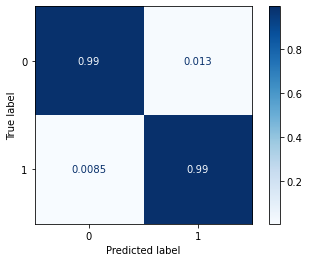


Testing Set
Accuracy: 0.6815206445115811

              precision    recall  f1-score   support

           0     0.5240    0.5566    0.5398      1333
           1     0.7688    0.7446    0.7565      2639

    accuracy                         0.6815      3972
   macro avg     0.6464    0.6506    0.6482      3972
weighted avg     0.6866    0.6815    0.6838      3972



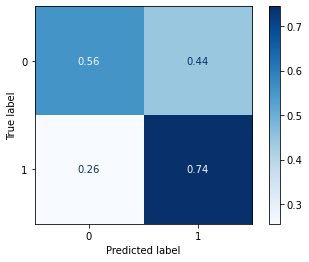

In [41]:
evaluate_model_ngrammWord(clf_lr_word, model_name="clf_lr_word")

In [42]:
grid_search_lr = GridSearchCV(clf_lr, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [43]:
clf_lr_char= grid_search_lr.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.1min finished


[CV] END .................................................... total time= 9.4min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.8min finished


[CV] END .................................................... total time= 8.9min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.9min finished


[CV] END .................................................... total time= 8.9min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.4min finished


[CV] END .................................................... total time= 8.4min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.4min finished


[CV] END .................................................... total time= 8.4min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.0min finished


Training Set
Accuracy: 0.9982736296935693

              precision    recall  f1-score   support

           0     0.9974    0.9974    0.9974      3114
           1     0.9987    0.9987    0.9987      6154

    accuracy                         0.9983      9268
   macro avg     0.9981    0.9981    0.9981      9268
weighted avg     0.9983    0.9983    0.9983      9268



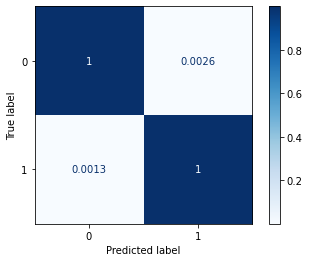


Testing Set
Accuracy: 0.701409869083585

              precision    recall  f1-score   support

           0     0.5375    0.5575    0.5473      1286
           1     0.7843    0.7703    0.7772      2686

    accuracy                         0.7014      3972
   macro avg     0.6609    0.6639    0.6623      3972
weighted avg     0.7044    0.7014    0.7028      3972



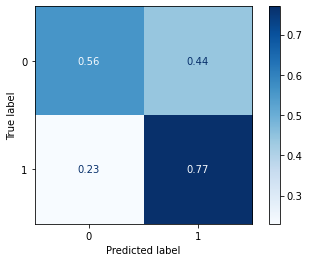

In [44]:
evaluate_model_ngrammChar(clf_lr_char, model_name="clf_lr_char")

In [45]:
del clf_lr

### **4.3 Random Forest**

In [46]:
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [47]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [48]:
clf_rf_word= grid_search_rf.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


[CV] END .................................................... total time= 1.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END .................................................... total time= 1.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


[CV] END .................................................... total time=18.4min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


[CV] END .................................................... total time= 2.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.8s finished


[CV] END .................................................... total time= 2.1min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.5s finished


Training Set
Accuracy: 0.7905697022011221

              precision    recall  f1-score   support

           0     0.6666    0.7346    0.6989      3067
           1     0.8618    0.8183    0.8394      6201

    accuracy                         0.7906      9268
   macro avg     0.7642    0.7764    0.7692      9268
weighted avg     0.7972    0.7906    0.7929      9268



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.5s finished


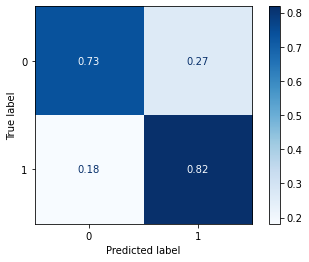

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.2s finished


Testing Set
Accuracy: 0.6714501510574018

              precision    recall  f1-score   support

           0     0.5088    0.6062    0.5532      1333
           1     0.7798    0.7044    0.7402      2639

    accuracy                         0.6715      3972
   macro avg     0.6443    0.6553    0.6467      3972
weighted avg     0.6888    0.6715    0.6775      3972



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.2s finished


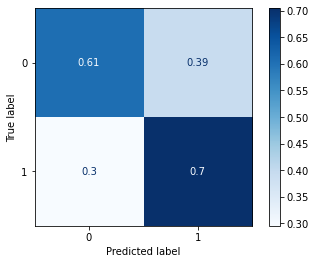

In [49]:
evaluate_model_ngrammWord(clf_rf_word, model_name="clf_rf_word")

In [50]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [51]:
clf_rf_char= grid_search_rf.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END .................................................... total time= 3.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


[CV] END .................................................... total time=19.1min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.4s finished


[CV] END .................................................... total time= 4.9min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


[CV] END .................................................... total time= 5.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.5s finished


[CV] END .................................................... total time= 4.6min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.1min finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.3s finished


Training Set
Accuracy: 0.8917781614156236

              precision    recall  f1-score   support

           0     0.8744    0.7916    0.8309      3114
           1     0.8994    0.9425    0.9204      6154

    accuracy                         0.8918      9268
   macro avg     0.8869    0.8670    0.8757      9268
weighted avg     0.8910    0.8918    0.8904      9268



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.1s finished


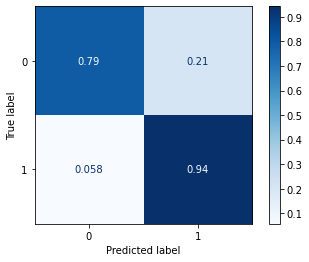

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.1s finished


Testing Set
Accuracy: 0.7583081570996979

              precision    recall  f1-score   support

           0     0.6526    0.5420    0.5922      1286
           1     0.7972    0.8619    0.8283      2686

    accuracy                         0.7583      3972
   macro avg     0.7249    0.7019    0.7102      3972
weighted avg     0.7504    0.7583    0.7518      3972



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.9s finished


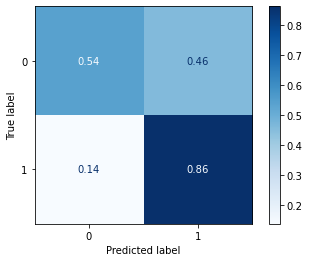

In [52]:
evaluate_model_ngrammChar(clf_rf_char, model_name="clf_rf_char")

In [53]:
del clf_rf

### **4.4 Neural Network**

In [55]:
clf_nn = MLPClassifier(alpha=1e-5,
                       hidden_layer_sizes=(150,100,50),
                       max_iter=300,
                       activation = 'relu',
                       solver='adam',
                       random_state=1)

In [56]:
grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [57]:
clf_nn_word = grid_search_nn.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=19.4min
[CV] END .................................................... total time=10.9min
[CV] END .................................................... total time= 9.0min
[CV] END .................................................... total time=19.8min
[CV] END .................................................... total time=16.9min


Training Set
Accuracy: 0.9977341389728097

              precision    recall  f1-score   support

           0     0.9984    0.9948    0.9966      3067
           1     0.9974    0.9992    0.9983      6201

    accuracy                         0.9977      9268
   macro avg     0.9979    0.9970    0.9974      9268
weighted avg     0.9977    0.9977    0.9977      9268



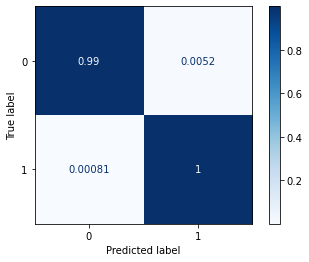


Testing Set
Accuracy: 0.7187814702920443

              precision    recall  f1-score   support

           0     0.5991    0.4899    0.5390      1333
           1     0.7641    0.8344    0.7977      2639

    accuracy                         0.7188      3972
   macro avg     0.6816    0.6621    0.6683      3972
weighted avg     0.7087    0.7188    0.7109      3972



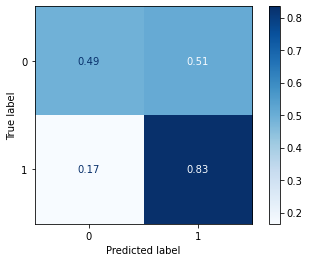

In [58]:
evaluate_model_ngrammWord(clf_nn_word, model_name="clf_nn_word")

In [60]:
grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [61]:

clf_nn_char = grid_search_nn.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time= 7.3min
[CV] END .................................................... total time=12.5min
[CV] END .................................................... total time=10.5min
[CV] END .................................................... total time=13.4min
[CV] END .................................................... total time= 9.7min


Training Set
Accuracy: 0.9961156668105309

              precision    recall  f1-score   support

           0     0.9961    0.9923    0.9942      3114
           1     0.9961    0.9981    0.9971      6154

    accuracy                         0.9961      9268
   macro avg     0.9961    0.9952    0.9956      9268
weighted avg     0.9961    0.9961    0.9961      9268



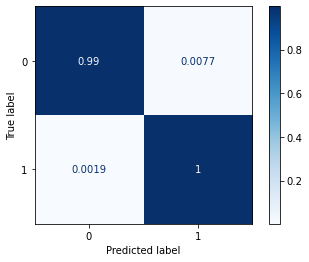


Testing Set
Accuracy: 0.7150050352467271

              precision    recall  f1-score   support

           0     0.5647    0.5226    0.5428      1286
           1     0.7793    0.8071    0.7930      2686

    accuracy                         0.7150      3972
   macro avg     0.6720    0.6648    0.6679      3972
weighted avg     0.7098    0.7150    0.7120      3972



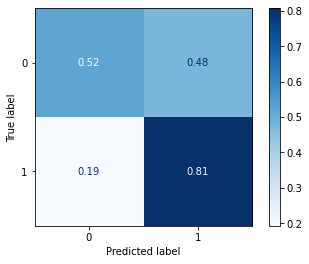

In [62]:
evaluate_model_ngrammChar(clf_nn_char, model_name="clf_nn_char")

In [63]:
del clf_nn

### **4.5 KNeighborsClassifier**

In [66]:
knn=KNeighborsClassifier(algorithm='auto',
                     leaf_size=30,
                     metric='minkowski',
                     metric_params=None, 
                     n_jobs=1, 
                     n_neighbors=18,
                     p=2,
                     weights='uniform')

In [67]:
grid_search_knn = GridSearchCV(knn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [68]:

knn_word = grid_search_knn.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=  11.3s
[CV] END .................................................... total time=   6.7s
[CV] END .................................................... total time=   6.1s
[CV] END .................................................... total time=   7.1s
[CV] END .................................................... total time=   6.5s


Training Set
Accuracy: 0.7041432887354337

              precision    recall  f1-score   support

           0     0.9265    0.1151    0.2048      3067
           1     0.6946    0.9955    0.8183      6201

    accuracy                         0.7041      9268
   macro avg     0.8106    0.5553    0.5115      9268
weighted avg     0.7714    0.7041    0.6152      9268



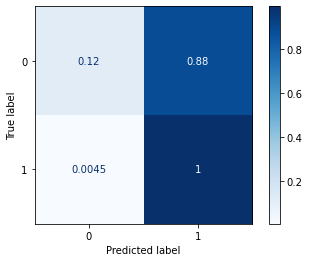


Testing Set
Accuracy: 0.6900805639476334

              precision    recall  f1-score   support

           0     0.8864    0.0878    0.1597      1333
           1     0.6833    0.9943    0.8100      2639

    accuracy                         0.6901      3972
   macro avg     0.7848    0.5410    0.4849      3972
weighted avg     0.7515    0.6901    0.5918      3972



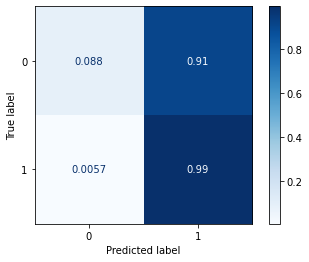

In [69]:
evaluate_model_ngrammWord(knn_word, model_name="knn_word")

In [70]:
grid_search_knn = GridSearchCV(knn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [71]:

knn_char = grid_search_knn.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=  13.4s
[CV] END .................................................... total time=  11.7s
[CV] END .................................................... total time=  11.5s
[CV] END .................................................... total time=  11.7s
[CV] END .................................................... total time=  11.7s


Training Set
Accuracy: 0.6890375485541649

              precision    recall  f1-score   support

           0     0.8841    0.0857    0.1563      3114
           1     0.6825    0.9943    0.8094      6154

    accuracy                         0.6890      9268
   macro avg     0.7833    0.5400    0.4829      9268
weighted avg     0.7502    0.6890    0.5900      9268



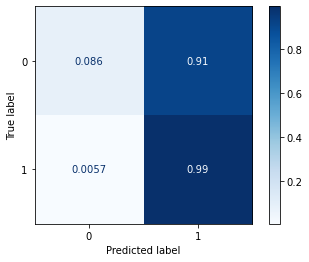


Testing Set
Accuracy: 0.6915911379657603

              precision    recall  f1-score   support

           0     0.8352    0.0591    0.1104      1286
           1     0.6882    0.9944    0.8135      2686

    accuracy                         0.6916      3972
   macro avg     0.7617    0.5268    0.4619      3972
weighted avg     0.7358    0.6916    0.5858      3972



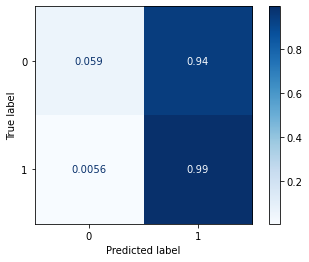

In [72]:
evaluate_model_ngrammChar(knn_char, model_name="knn_char")

In [73]:
del knn

# **5. Other Features**

In [74]:
# #Add Word Tokenizer without Stemming
def basic_tokenize(tweet):
     """Removes punctuation & excess whitespace, sets to lowercase.
        Returns a list of tokens."""
     list_tokens = []
     for t in tweet:
       sentence = re.sub(r'[^\w\s]','',t.lower())
       list_tokens.append(nltk.word_tokenize(sentence))
     tokens = [item for sublist in list_tokens for item in sublist]
     return tokens

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    words = basic_tokenize(tweet) #Get text only
    syllables = []
    for word in words:
      syllables.append(textstat.syllable_count(word))

    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_words = len(words)
    num_unique_terms = len(set(words))

    avg_syl = []
    for s in syllables:
      avg_syl.append(int(s+0.001)/int(num_words+0.001))
    avg = sum(avg_syl) / len(avg_syl)
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg)),2)

    twitter_objs = []
    retweet = 0
    if "rt" in words:
      retweet = 1
    features = [FKRA, FRE, avg, num_chars, num_chars_total, num_words,
                num_unique_terms,  retweet]
    return features


def get_feature_array(tweets):
  feats = []
  for t in tweets:
    feats.append(other_features(t))
  return np.array(feats)


  
other_features_names = ["FKRA", "FRE","avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_words", "num_unique_words", "is_retweet"]

                       

feats = get_feature_array(tweets)

### **5.1 Adding New Features to Data**

In [75]:
M_new_words = np.concatenate([tfidf_words,pos,feats],axis=1)
M_new_words.shape

M_new_chars = np.concatenate([tfidf_chars,pos,feats],axis=1)
M_new_chars.shape

(13240, 19472)

In [76]:
X_new_words = pd.DataFrame(M_new_words)
X_train_word, X_test_word, y_train_word, y_test_word = train_test_split(X_new_words, y, test_size = 0.3, random_state = 42, shuffle=True)

In [77]:
X_new_chars = pd.DataFrame(M_new_chars)
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(X_new_chars, y, test_size = 0.3, random_state = 42, shuffle=True)

### **5.2 Testing MAchine Learning Models on Data with New Features**



#### **5.2.1 Linear Regression Model**



In [78]:
c_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [79]:
param_grid = [{}]
grid_search_lr = GridSearchCV(c_lr, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [80]:
c_lr_char = grid_search_lr.fit(X_train_char, y_train_char)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 59.1min finished


[CV] END .................................................... total time=59.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.6min finished


[CV] END .................................................... total time= 8.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.3min finished


[CV] END .................................................... total time= 8.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.3min finished


[CV] END .................................................... total time= 8.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.2min finished


[CV] END .................................................... total time= 8.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 11.4min finished


Training Set
Accuracy: 0.9001942166594734

              precision    recall  f1-score   support

           0     0.8184    0.8976    0.8562      3067
           1     0.9468    0.9015    0.9236      6201

    accuracy                         0.9002      9268
   macro avg     0.8826    0.8995    0.8899      9268
weighted avg     0.9043    0.9002    0.9013      9268



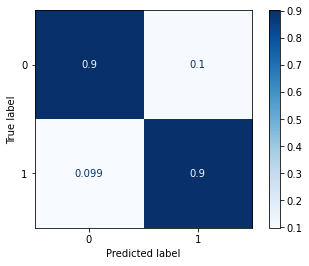


Testing Set
Accuracy: 0.7155085599194361

              precision    recall  f1-score   support

           0     0.5718    0.6062    0.5885      1333
           1     0.7948    0.7707    0.7826      2639

    accuracy                         0.7155      3972
   macro avg     0.6833    0.6884    0.6856      3972
weighted avg     0.7200    0.7155    0.7175      3972



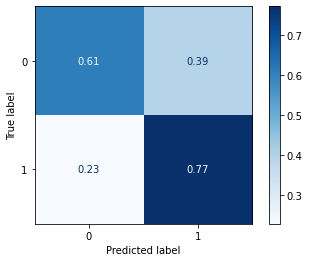

In [81]:
evaluate_model_ngrammChar(c_lr_char, model_name="lr_chars_newFeatures")

#### **5.2.2 Random Forest Classifier**



In [82]:
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')




In [83]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [84]:
clf_rf_char= grid_search_rf.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


[CV] END .................................................... total time= 2.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END .................................................... total time= 2.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END .................................................... total time= 2.4min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END .................................................... total time= 2.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END .................................................... total time= 2.7min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.4s finished


Training Set
Accuracy: 0.8944756150194216

              precision    recall  f1-score   support

           0     0.8775    0.7917    0.8324      3067
           1     0.9017    0.9453    0.9230      6201

    accuracy                         0.8945      9268
   macro avg     0.8896    0.8685    0.8777      9268
weighted avg     0.8937    0.8945    0.8930      9268



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.4s finished


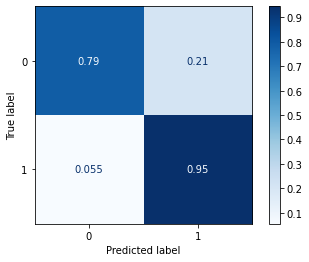

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


Testing Set
Accuracy: 0.7532729103726082

              precision    recall  f1-score   support

           0     0.6660    0.5311    0.5910      1333
           1     0.7851    0.8655    0.8234      2639

    accuracy                         0.7533      3972
   macro avg     0.7256    0.6983    0.7072      3972
weighted avg     0.7452    0.7533    0.7454      3972



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


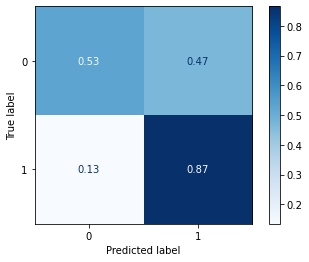

In [85]:
evaluate_model_ngrammChar(clf_rf_char, model_name="clf_rf_char_newFeatures")

#### **5.2.2 Neural Network**



In [87]:
clf_nn = MLPClassifier(alpha=1e-5,
                       hidden_layer_sizes=(150,100,50),
                       max_iter=300,
                       activation = 'relu',
                       solver='adam',
                       random_state=1)

In [88]:
grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)


In [89]:
clf_nn_char = grid_search_nn.fit(X_train_char, y_train_char)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time= 8.0min
[CV] END .................................................... total time=32.7min
[CV] END .................................................... total time= 8.5min
[CV] END .................................................... total time=14.0min
[CV] END .................................................... total time=11.2min


Training Set
Accuracy: 0.9974104445403539

              precision    recall  f1-score   support

           0     0.9958    0.9964    0.9961      3067
           1     0.9982    0.9979    0.9981      6201

    accuracy                         0.9974      9268
   macro avg     0.9970    0.9972    0.9971      9268
weighted avg     0.9974    0.9974    0.9974      9268



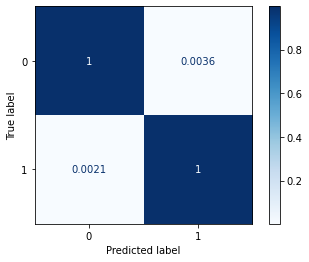


Testing Set
Accuracy: 0.7079556898288016

              precision    recall  f1-score   support

           0     0.5696    0.5311    0.5497      1333
           1     0.7710    0.7973    0.7839      2639

    accuracy                         0.7080      3972
   macro avg     0.6703    0.6642    0.6668      3972
weighted avg     0.7034    0.7080    0.7053      3972



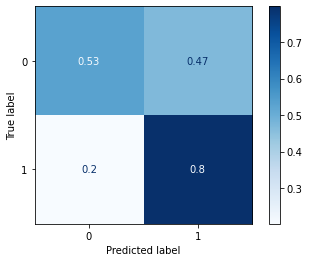

In [90]:
evaluate_model_ngrammChar(clf_nn_char, model_name="clf_nn_char_newFeatures")

### **5.2 TF-IDF without stopwords**

In [91]:
tfidf_char_no_stopwords = TfidfVectorizer(
    analyzer='char',
    preprocessor=preprocess,
    ngram_range=(2, 6),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75)

In [92]:
#Construct tfidf matrix and get relevant scores
tfidf =tfidf_char_no_stopwords.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(tfidf_char_no_stopwords.get_feature_names())}
idf_vals = tfidf_char_no_stopwords.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores


In [93]:
array = np.concatenate([tfidf,pos],axis=1)

In [94]:
array.shape

(13240, 14464)

In [95]:
X_new_noStopWords = pd.DataFrame(array)
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(X_new_noStopWords, y, test_size = 0.3, random_state = 42, shuffle=True)

In [96]:
clf_nn = MLPClassifier(alpha=1e-5,
                       hidden_layer_sizes=(150,100,50),
                       max_iter=300,
                       activation = 'relu',
                       solver='adam',
                       random_state=1)


In [97]:
grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)




In [98]:
clf_nn_chars = grid_search_nn.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time= 8.9min
[CV] END .................................................... total time= 7.7min
[CV] END .................................................... total time= 8.8min
[CV] END .................................................... total time=10.2min
[CV] END .................................................... total time=16.3min


Training Set
Accuracy: 0.9968709538195943

              precision    recall  f1-score   support

           0     0.9980    0.9925    0.9953      3067
           1     0.9963    0.9990    0.9977      6201

    accuracy                         0.9969      9268
   macro avg     0.9972    0.9958    0.9965      9268
weighted avg     0.9969    0.9969    0.9969      9268



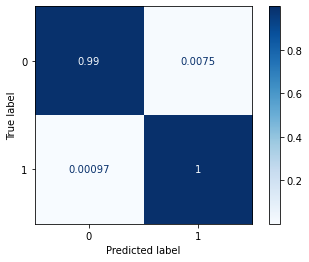


Testing Set
Accuracy: 0.7293554884189325

              precision    recall  f1-score   support

           0     0.6282    0.4741    0.5404      1333
           1     0.7637    0.8583    0.8082      2639

    accuracy                         0.7294      3972
   macro avg     0.6959    0.6662    0.6743      3972
weighted avg     0.7182    0.7294    0.7183      3972



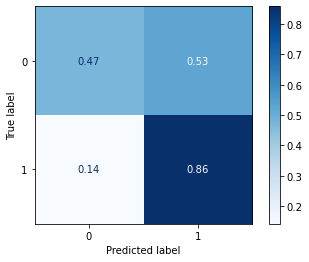

In [99]:
evaluate_model_ngrammChar(clf_nn_chars, model_name="clf_nn_chars_noStopWords")

In [100]:
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [101]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [102]:
clf_rf_chars= grid_search_rf.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finished


[CV] END .................................................... total time= 4.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


[CV] END .................................................... total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.9s finished


[CV] END .................................................... total time= 3.2min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV] END .................................................... total time= 3.3min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


[CV] END .................................................... total time= 3.3min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.6s finished


Training Set
Accuracy: 0.8952309020284851

              precision    recall  f1-score   support

           0     0.8748    0.7975    0.8344      3067
           1     0.9040    0.9436    0.9234      6201

    accuracy                         0.8952      9268
   macro avg     0.8894    0.8705    0.8789      9268
weighted avg     0.8944    0.8952    0.8939      9268



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.6s finished


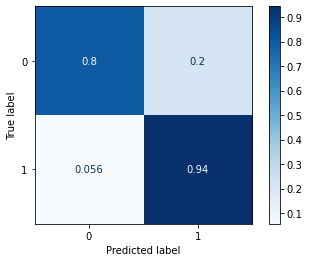

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.7s finished


Testing Set
Accuracy: 0.751007049345418

              precision    recall  f1-score   support

           0     0.6575    0.5386    0.5922      1333
           1     0.7865    0.8583    0.8208      2639

    accuracy                         0.7510      3972
   macro avg     0.7220    0.6985    0.7065      3972
weighted avg     0.7432    0.7510    0.7441      3972



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.4s finished


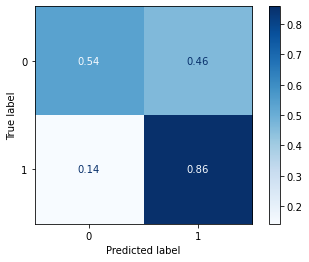

In [103]:
evaluate_model_ngrammChar(clf_rf_chars, model_name="clf_rf_chars_noStopWords")